In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_hc = pd.read_csv('train.csv', index_col=0)
df_hc.head()

,lepton_1_pT,lepton_1_eta,lepton_1_phi,lepton_2_pT,lepton_2_eta,lepton_2_phi,missing_energy_magnitude,missing_energy_phi,MET_rel,axial_MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos(theta_r1),class
0,0.841381,1.832647,-0.689286,0.781839,0.572864,1.577097,0.398978,-0.683847,0.001826,0.651397,0.865560,0.429017,0.439840,0.000000,0.796105,0.342497,0.461542,0.005710,0.0
1,0.663798,2.058290,0.681435,1.054036,0.575352,-1.001445,0.462154,-0.833411,0.199734,0.215158,0.949988,0.618046,0.577324,0.000000,0.962927,0.333800,1.455247,0.101246,0.0
2,1.792225,-1.099978,0.088109,0.573157,-0.472629,1.642084,1.203374,1.506731,0.457695,-0.640507,1.157024,1.585432,1.215963,0.000000,1.113292,0.645729,0.721326,0.613326,1.0
3,0.893018,0.297782,-1.274870,1.316164,1.593303,0.672115,0.307014,-1.189868,0.064561,0.430909,1.162625,0.548821,0.418897,0.163908,1.157707,0.298163,0.803802,0.038902,0.0
4,1.338997,0.350023,-1.518510,1.482963,-0.491807,0.340170,0.415071,-1.292034,0.240712,0.611775,1.307798,0.697804,0.473487,0.429977,1.287935,0.330327,0.717237,0.003147,1.0


In [3]:
df_hcc = df_hc.copy()

# Preprocessing

In [4]:
df_hcc.columns

Index(['lepton_1_pT', 'lepton_1_eta', 'lepton_1_phi', 'lepton_2_pT',
       'lepton_2_eta', 'lepton_2_phi', 'missing_energy_magnitude',
       'missing_energy_phi', 'MET_rel', 'axial_MET', 'M_R', 'M_TR_2', 'R',
       'MT2', 'S_R', 'M_Delta_R', 'dPhi_r_b', 'cos(theta_r1)', 'class'],
      dtype='object')

<AxesSubplot:>

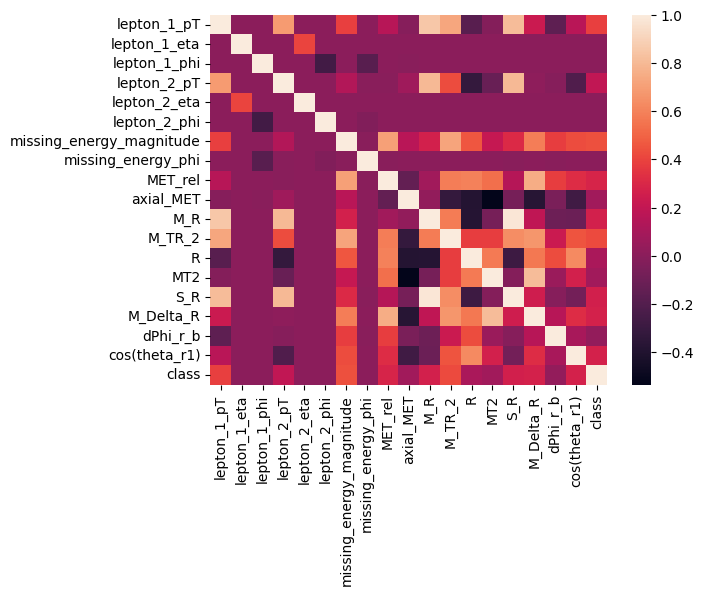

In [5]:
sns.heatmap(df_hcc.corr())

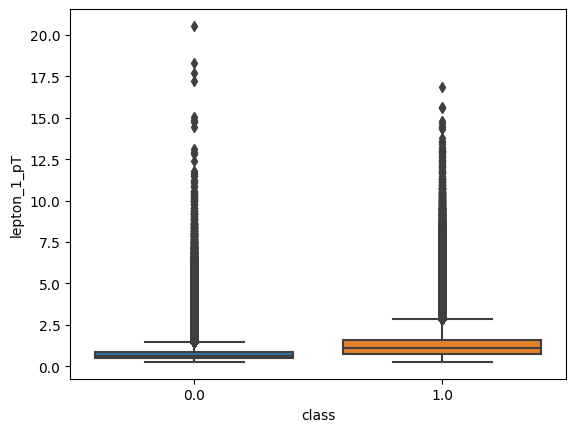

In [6]:
sns.boxplot(data=df_hcc, y='lepton_1_pT', x='class')
df_hcc=df_hcc[df_hcc['lepton_1_pT'] < 5]

In [7]:
# sns.boxplot(data=df_hcc, y='lepton_2_pT', x='class')
# df_hcc=df_hcc[df_hcc['lepton_2_pT'] < 3]

In [8]:
df_hcc.shape

(3491438, 19)

In [9]:
df_hcc = df_hcc.drop(columns =['lepton_1_phi', 'missing_energy_phi', 'lepton_2_phi'], axis=1)

# Split for Calculation

In [10]:
X, y = df_hcc.loc[:, df_hcc.columns != 'class'].to_numpy(dtype=np.float_), df_hcc['class'].to_numpy(dtype=np.float_)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [11]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler_train_test = StandardScaler()
X_train = scaler_train_test.fit_transform(X_train)
X_test = scaler_train_test.transform(X_test)

scaler_full = StandardScaler()
X = scaler_full.fit_transform(X)

# Model Training

#### Random Forest Model

In [68]:
from sklearn.ensemble import RandomForestClassifier

In [259]:
model_rf = RandomForestClassifier(n_estimators=160, n_jobs=-1)
model_rf.fit(X_train ,y_train)
model_rf.feature_importances_
model_rf.score(X_test, y_test)

0.8003259400132896

In [286]:
model_rf = RandomForestClassifier(n_estimators=130, n_jobs=-1, warm_start=True)
model_rf.fit(X, y)
model_rf.score(X, y)

0.9999979950954306

In [287]:
model_rf.predict(X)

array([0., 0., 1., ..., 1., 0., 0.])

In [288]:
model_rf.n_estimators=160
bad = (model_rf.predict(X) !=  y)
X_bad, y_bad = X[bad], y[bad]
model_rf.fit(X_bad, y_bad)
model_rf.score(X, y)

0.9999799509543059

#### Gradient Boost Model

In [15]:
from sklearn.ensemble import HistGradientBoostingClassifier
model_xg = HistGradientBoostingClassifier(l2_regularization=0.2, max_leaf_nodes=150, random_state=42)
model_xg.fit(X_train, y_train)
model_xg.score(X_test, y_test)

0.8031385330980914

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'learning_rate': (0.01, 0.1),
    'random_state': (42),
    'max_leaf_nodes': (200, 250, 300),
    'l2_regularization': (0.3, 0.4, 0.5)}

model_grid_search = GridSearchCV(HistGradientBoostingClassifier(), param_grid=param_grid,
                                 n_jobs=-1, cv=5, verbose=2)
model_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=HistGradientBoostingClassifier(), n_jobs=-1,
             param_grid={'l2_regularization': (0.3, 0.4, 0.5),
                         'learning_rate': (0.01, 0.1),
                         'max_leaf_nodes': (250, 300)},
             verbose=2)

In [29]:
print(model_grid_search.best_params_)
print(model_grid_search.best_estimator_)
model_grid_search.score(X_test, y_test)

{'l2_regularization': 0.5, 'learning_rate': 0.1, 'max_leaf_nodes': 250}
HistGradientBoostingClassifier(l2_regularization=0.5, max_leaf_nodes=250)


0.8026578571428571

In [16]:
# model_xg = HistGradientBoostingClassifier(l2_regularization=model_grid_search.best_params_['l2_regularization'],
#                                 learning_rate=model_grid_search.best_params_['learning_rate'],
#                                 max_leaf_nodes=model_grid_search.best_params_['max_leaf_nodes'], random_state=42)

model_xg = HistGradientBoostingClassifier(l2_regularization=0.4, max_leaf_nodes=300, learning_rate=0.1, random_state=42)
model_xg.fit(X_train, y_train)
model_xg.score(X_test, y_test)

0.8032624074880279

In [58]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    model_xg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)
sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=df_hcc.columns[sorted_importances_idx],
)
importances

,lepton_2_phi,lepton_2_pT,M_TR_2,R,M_R,cos(theta_r1),lepton_2_eta,MT2,dPhi_r_b,lepton_1_eta,S_R,M_Delta_R,MET_rel,axial_MET,lepton_1_pT,missing_energy_magnitude
0,0.000021,0.000599,0.001191,0.001973,0.002737,0.005312,0.006392,0.006668,0.007922,0.010072,0.012138,0.013403,0.016369,0.034832,0.085533,0.160604
1,0.000019,0.000639,0.001044,0.002061,0.002881,0.005556,0.006708,0.007049,0.008086,0.009826,0.011669,0.013686,0.016316,0.034630,0.086081,0.160135
2,0.000028,0.000614,0.001044,0.001845,0.002788,0.005516,0.006536,0.006683,0.008064,0.010035,0.011613,0.013257,0.016366,0.034716,0.085586,0.159514
3,-0.000004,0.000584,0.001075,0.001884,0.002828,0.005481,0.006565,0.006772,0.007969,0.010090,0.011840,0.013497,0.016255,0.034389,0.085687,0.159897
4,0.000039,0.000655,0.001023,0.002086,0.002920,0.005543,0.006561,0.006879,0.007876,0.009744,0.011638,0.013606,0.016293,0.034760,0.085899,0.160349
5,-0.000011,0.000480,0.001239,0.001942,0.002943,0.005527,0.006642,0.006449,0.007751,0.009862,0.011777,0.013415,0.016434,0.034746,0.085237,0.159877
6,0.000004,0.000646,0.001106,0.001955,0.002853,0.005303,0.006556,0.006996,0.007879,0.009935,0.011348,0.013653,0.016325,0.034434,0.085939,0.159915
7,-0.000009,0.000547,0.001209,0.001983,0.002566,0.005453,0.006661,0.006986,0.007961,0.009961,0.011780,0.013470,0.016277,0.034928,0.085734,0.159958
8,0.000044,0.000564,0.000841,0.001910,0.002941,0.005326,0.006629,0.006776,0.007917,0.010030,0.011613,0.013624,0.016244,0.034833,0.085687,0.159764
9,0.000006,0.000741,0.000931,0.002040,0.003026,0.005559,0.006485,0.006840,0.007750,0.009934,0.011671,0.013624,0.016248,0.034581,0.085798,0.160231


In [17]:
# model_xg = HistGradientBoostingClassifier(l2_regularization=model_grid_search.best_params_['l2_regularization'],
#                                 learning_rate=model_grid_search.best_params_['learning_rate'],
#                                 max_leaf_nodes=model_grid_search.best_params_['max_leaf_nodes'], random_state=42)

model_xg = HistGradientBoostingClassifier(l2_regularization=0.4, max_leaf_nodes=300, learning_rate=0.1, random_state=42)
model_xg.fit(X, y)
model_xg.score(X, y)

0.8065184030190425

#### Adaboost Model

In [328]:
from sklearn.ensemble import AdaBoostClassifier
model_ada = AdaBoostClassifier(n_estimators=150, learning_rate=0.1)
model_ada.fit(X_train, y_train)
model_ada.score(X_test, y_test)

TypeError: AdaBoostClassifier.__init__() got an unexpected keyword argument 'n_jobs'

#### VC

# Final Predictions 

In [18]:
# X_t = pd.read_csv('test.csv', index_col=0).to_numpy(dtype=np.float_)
X_t = pd.read_csv('test.csv', index_col=0).drop(columns=['lepton_1_phi', 'missing_energy_phi', 'lepton_2_phi'], axis=1).to_numpy(dtype=np.float_)
X_t = scaler_full.transform(X_t)
# output_rf = pd.Series(model_rf.predict(X_t), name='class')
output_xg = pd.Series(model_xg.predict(X_t), name='class')

In [19]:
# output_rf.to_csv('res_rf.csv', index=True, index_label='Id')
output_xg.to_csv('res_xg.csv', index=True, index_label='Id')

In [20]:
y_ay = pd.read_csv('y_ayush.csv', index_col=0)
y_ay['class']
# print(np.sum(output_rf == y_ay['class'])/len(output_rf))
print(np.sum(output_xg == y_ay['class'])/len(output_xg))

0.9742386666666667
